# 摘要

# 理论模型

油菜籽经机械压榨提取油脂后的剩余余物为菜籽饼。菜籽饼通常有两种：一种是没有浸出车间的小型油厂，使用小型或 95 型及 200 型榨油机压榨后得到的菜籽饼，含油率一般在 5-8%，个别可达到 10%，可直接销售给饲料养殖企业，但由于含油量过高，销售价格一般低于菜籽粕。另一种是目前国内绝大多数油厂使用202 型或 338 型预压榨榨油机榨油后得到的菜籽饼，通常称做预榨菜籽饼，含油率一般在 15-18%。预榨菜籽饼由于含油率高，只是生产过程中的中间产品，油厂通常会直接输送到浸出车间进一步提取剩余油脂，菜籽饼浸出提油后的残渣称为菜籽粕。菜籽粕一般呈黄色或浅褐色，形状为碎片或粗粉末并夹杂小颗粒。

![菜籽粕](.\images\菜籽粕.PNG)


## 用途

根据菜籽粕中芥酸和硫代葡萄糖苷含量不同，通常将菜籽粕分为：普通菜籽粕和“双低菜籽粕”。

菜籽粕在水产饲料中使用最为广泛，由于其蛋白质氨基酸组成合理，价格便宜，在家禽饲料、猪饲料和反刍动物饲料中都有添加。

菜籽粕除了直接用做饲料蛋白原料，还可用来生产有机肥料。经过脱壳脱毒处理的菜籽粕还可提取菜籽蛋白，用来制作酱油或用作食品添加剂。此外，菜籽粕还可用来提取植酸、单宁等化工原料。

## 生产

### 工艺流程

20 世纪 70 年代之前，菜籽制油工艺主要是一次压榨法，部分地区采用土榨法，菜籽榨油后得到的菜籽饼直接作为饲料或肥料使用。

20 世纪 70 年代以来，浸出法制油得到大量应用。菜籽加工行业普遍采用预榨浸出工艺，菜籽粕经浸出后获得的菜籽粕产量明显提高，统计数据显示，目前中国菜籽饼粕市场中，菜籽粕所占比重超过 90%，菜籽饼所占比重 10%。

![菜籽粕生产工艺](.\images\菜籽粕生产工艺.PNG)

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

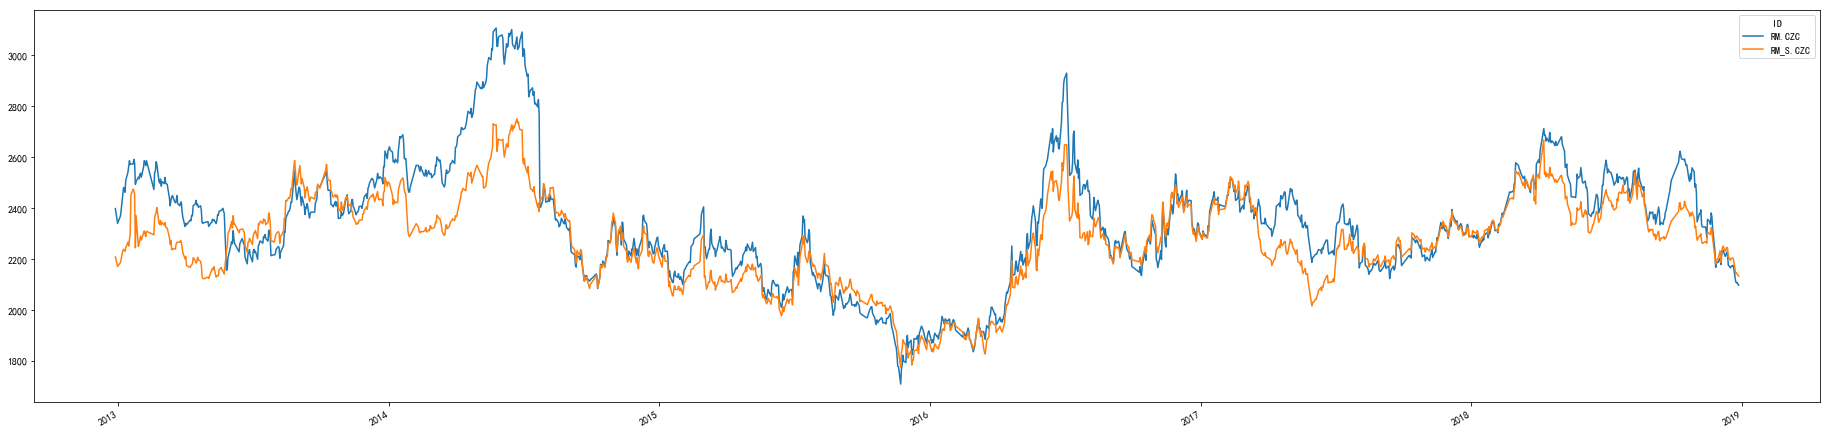

In [2]:
# 参数设置和数据准备
Exchange = "CZCE"
MID, SID = "RM.CZC", "RM_S.CZC"# 主力合约, 次主力合约
StartDT = dt.datetime(2012, 12, 28)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"
WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=FutureIDMap.columns.tolist(), dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes);

# 附录
​
## 期货

![菜籽粕期货合约](.\images\菜籽粕期货合约.PNG)

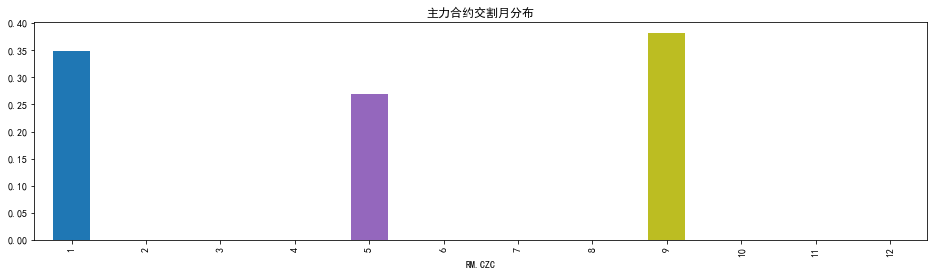

In [3]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

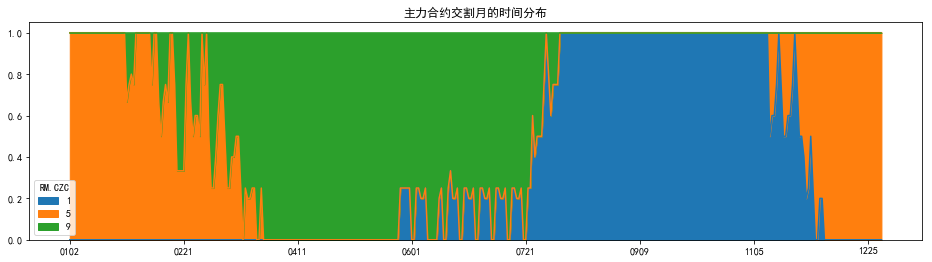

In [4]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);